In [4]:
# pandas for analysis
import pandas as pd

# system and operating system to help me grab some functions
import sys
import os
os.chdir('..')
sys.path.append('./economic_outlook/working_files')
sys.path.append('./economic_outlook/pairs_trading')


from working_files.functions import *


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from openbb import obb
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import adfuller
obb.user.preferences.output_type = 'dataframe'


In [5]:
stocks_list = [
    "AAPL",  # Apple Inc.
    "MSFT",  # Microsoft Corporation
    "GOOGL", # Alphabet Inc. (Class A)
    "AMZN",  # Amazon.com Inc.
    "META",  # Meta Platforms Inc.
    "NVDA",  # NVIDIA Corporation
    "TSLA",  # Tesla Inc.
    "JPM",   # JPMorgan Chase & Co.
    "V",     # Visa Inc.
    "AMD", # AMD 
    "KO", # Coca Cola
    "SBUX", #Starbucks
    "PEP", # Pepsi
    "GE", # General Electric
    "GM", # General Motors
    "NFLX", # Netflix
    "RBLX", # Roblox
    "SONY", # Sony
    "WMT", # Walmart
    "IBM", # IBM
    "TGT", # target
    "COF" ,# Capital One,
    "PLTR", # Palantir,
    "MELI", # MercadoLibre
    "ROAD", #Construction
    "QUBT", # Quantum Computing
    "SHOP", # Shopify
    "ADBE" ,# Adobe
    "BRK-B",# berkshire hathaway
    "OKLO", # Oklo Inc
    "SMR", # Nuscale Power Corp
    "HOOD", # Robinhood 
    "GIL", # gildan
    "SPY" # SP 500
    

]


In [6]:
def data_collecter(list_stocks):
    stock_data = {}
    for stock in list_stocks:
        df = adding_relevant_columns(stock_insights(obb.equity.price.historical(stock, provider = 'yfinance')))
        stock_data[stock] = df
    return stock_data

all_data = data_collecter(stocks_list)

def combining_stock_data(stocks_of_interest, timeperiod = '2024-01-01'):
    dataframe = pd.DataFrame()
    names = list()
    for name in stocks_of_interest:
        dataframe = pd.concat([dataframe,stock_insights(obb.equity.price.historical(name, provider = 'yfinance'))['close']],
                    axis = 1)
        names.append(name)
        dataframe.columns = names
    dataframe.index = pd.to_datetime(dataframe.index)
    dataframe = dataframe[dataframe.index > pd.to_datetime(timeperiod)]
    correlation = dataframe.corr()
    return dataframe, correlation

stock_data, correlation = combining_stock_data(stocks_list)

def identifying_pairs_stocks_highly_correlated(matrix = correlation):
    threshhold = 0.80
    highly_correlated_stocks = {}
    for column in range(len(matrix.columns)):
        for row in range(column + 1, len(matrix)):
            # column value
            col1 = matrix.columns[column]
            # row value
            col2 = matrix.columns[row]
            true_correlation_value = matrix.loc[col1,col2]
            if true_correlation_value > threshhold:
                highly_correlated_stocks[true_correlation_value] = [col1,col2]
    return highly_correlated_stocks



correlated_stocks = identifying_pairs_stocks_highly_correlated()




def calculating_spread(correlated_stocks=correlated_stocks, data_dictionary=all_data):
    spreads = {}
    
    for pair in correlated_stocks.values():
        stock1, stock2 = pair[0], pair[1]
        closing_1 = data_dictionary[stock1]['close']
        closing_2 = data_dictionary[stock2]['close']
        
        # adding in this error exception since I would assume that specific pairs of stocks may not have
        # the same length in series of the series
        
        if len(closing_1) != len(closing_2):
             print(f"Error: Time series for {stock1} and {stock2} have different lengths. Skipping this pair.")
             continue

        # same rule applies here:
        if isinstance(closing_1, pd.Series) and isinstance(closing_2, pd.Series):
            if not closing_1.index.equals(closing_2.index):
                 print(f"Error: Pandas Series indices for {stock1} and {stock2} are not aligned.  Resetting indices")
                 closing_1 = closing_1.reset_index(drop=True)
                 closing_2 = closing_2.reset_index(drop=True)
        
        spread = closing_1 - closing_2
        ratio = closing_1 / closing_2

        # Cointegration and stationarity
        coint_result = ts.coint(closing_1, closing_2)
        pvalue = coint_result[1]

        stock1_ADF_p = adfuller(closing_1)[1]
        stock2_ADF_p = adfuller(closing_2)[1]
        spread_ADF_p = adfuller(spread)[1]
        ratio_ADF_p = adfuller(ratio)[1]

        # Count how many tests pass the 0.05 threshold
        tests_passed = sum([
            pvalue < 0.05,
            stock1_ADF_p < 0.05,
            stock2_ADF_p < 0.05
        ])

        if tests_passed >= 1:
            spreads[(stock1, stock2)] = {
                "ratio" : ratio,
                "spread": spread,
                "pvalue": pvalue,
                "ADF_stock1": stock1_ADF_p,
                "ADF_stock2": stock2_ADF_p,
                "ADF_spread": spread_ADF_p,
                "ADF_ratio": ratio_ADF_p
            }
    return spreads

stock_spread = calculating_spread()


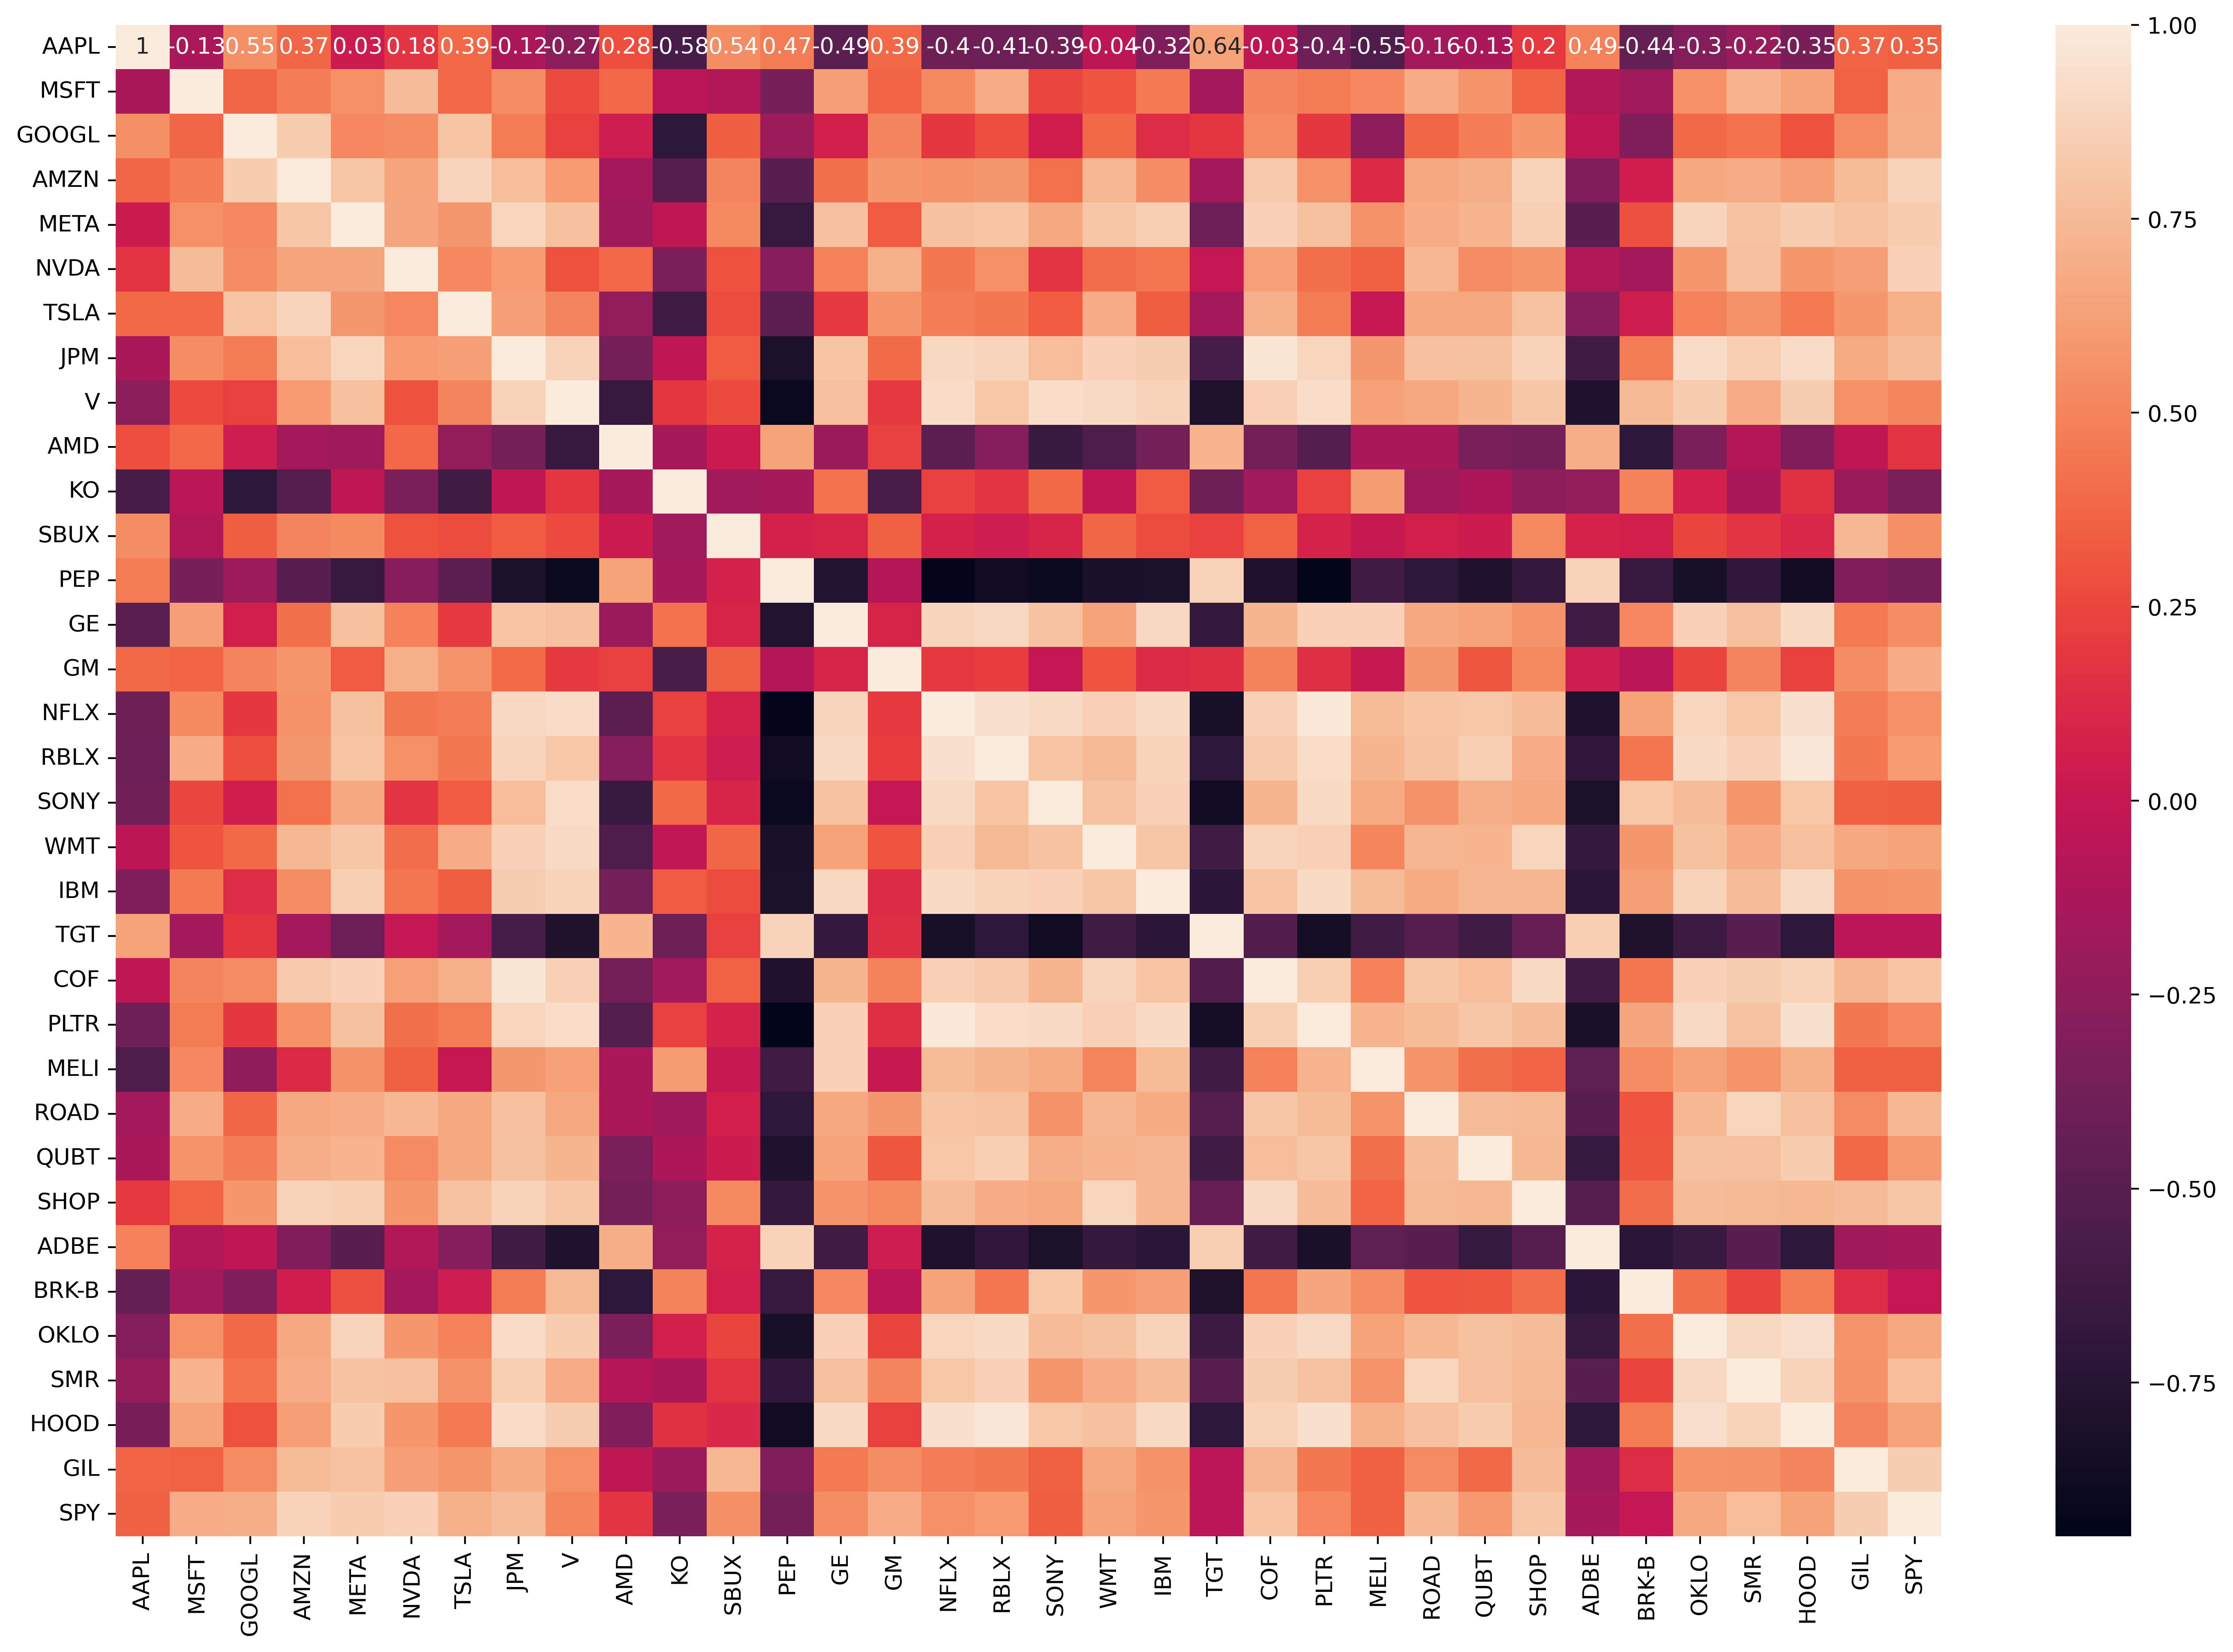

In [7]:
def heatmap_of_correlation(correlated_stocks = stock_spread):
    os.makedirs('./graphs/heat_graph/', exist_ok = True)
    directory = './graphs/heat_graph/'
    figure(figsize = (18,12), dpi = 400)
    plotted = sns.heatmap(correlation, annot = True)
    plt.savefig(f'{directory} correlation_heat_map.png', dpi = 25, bbox_inches = 'tight')
    plt.close()
    
heatmap_of_correlation()


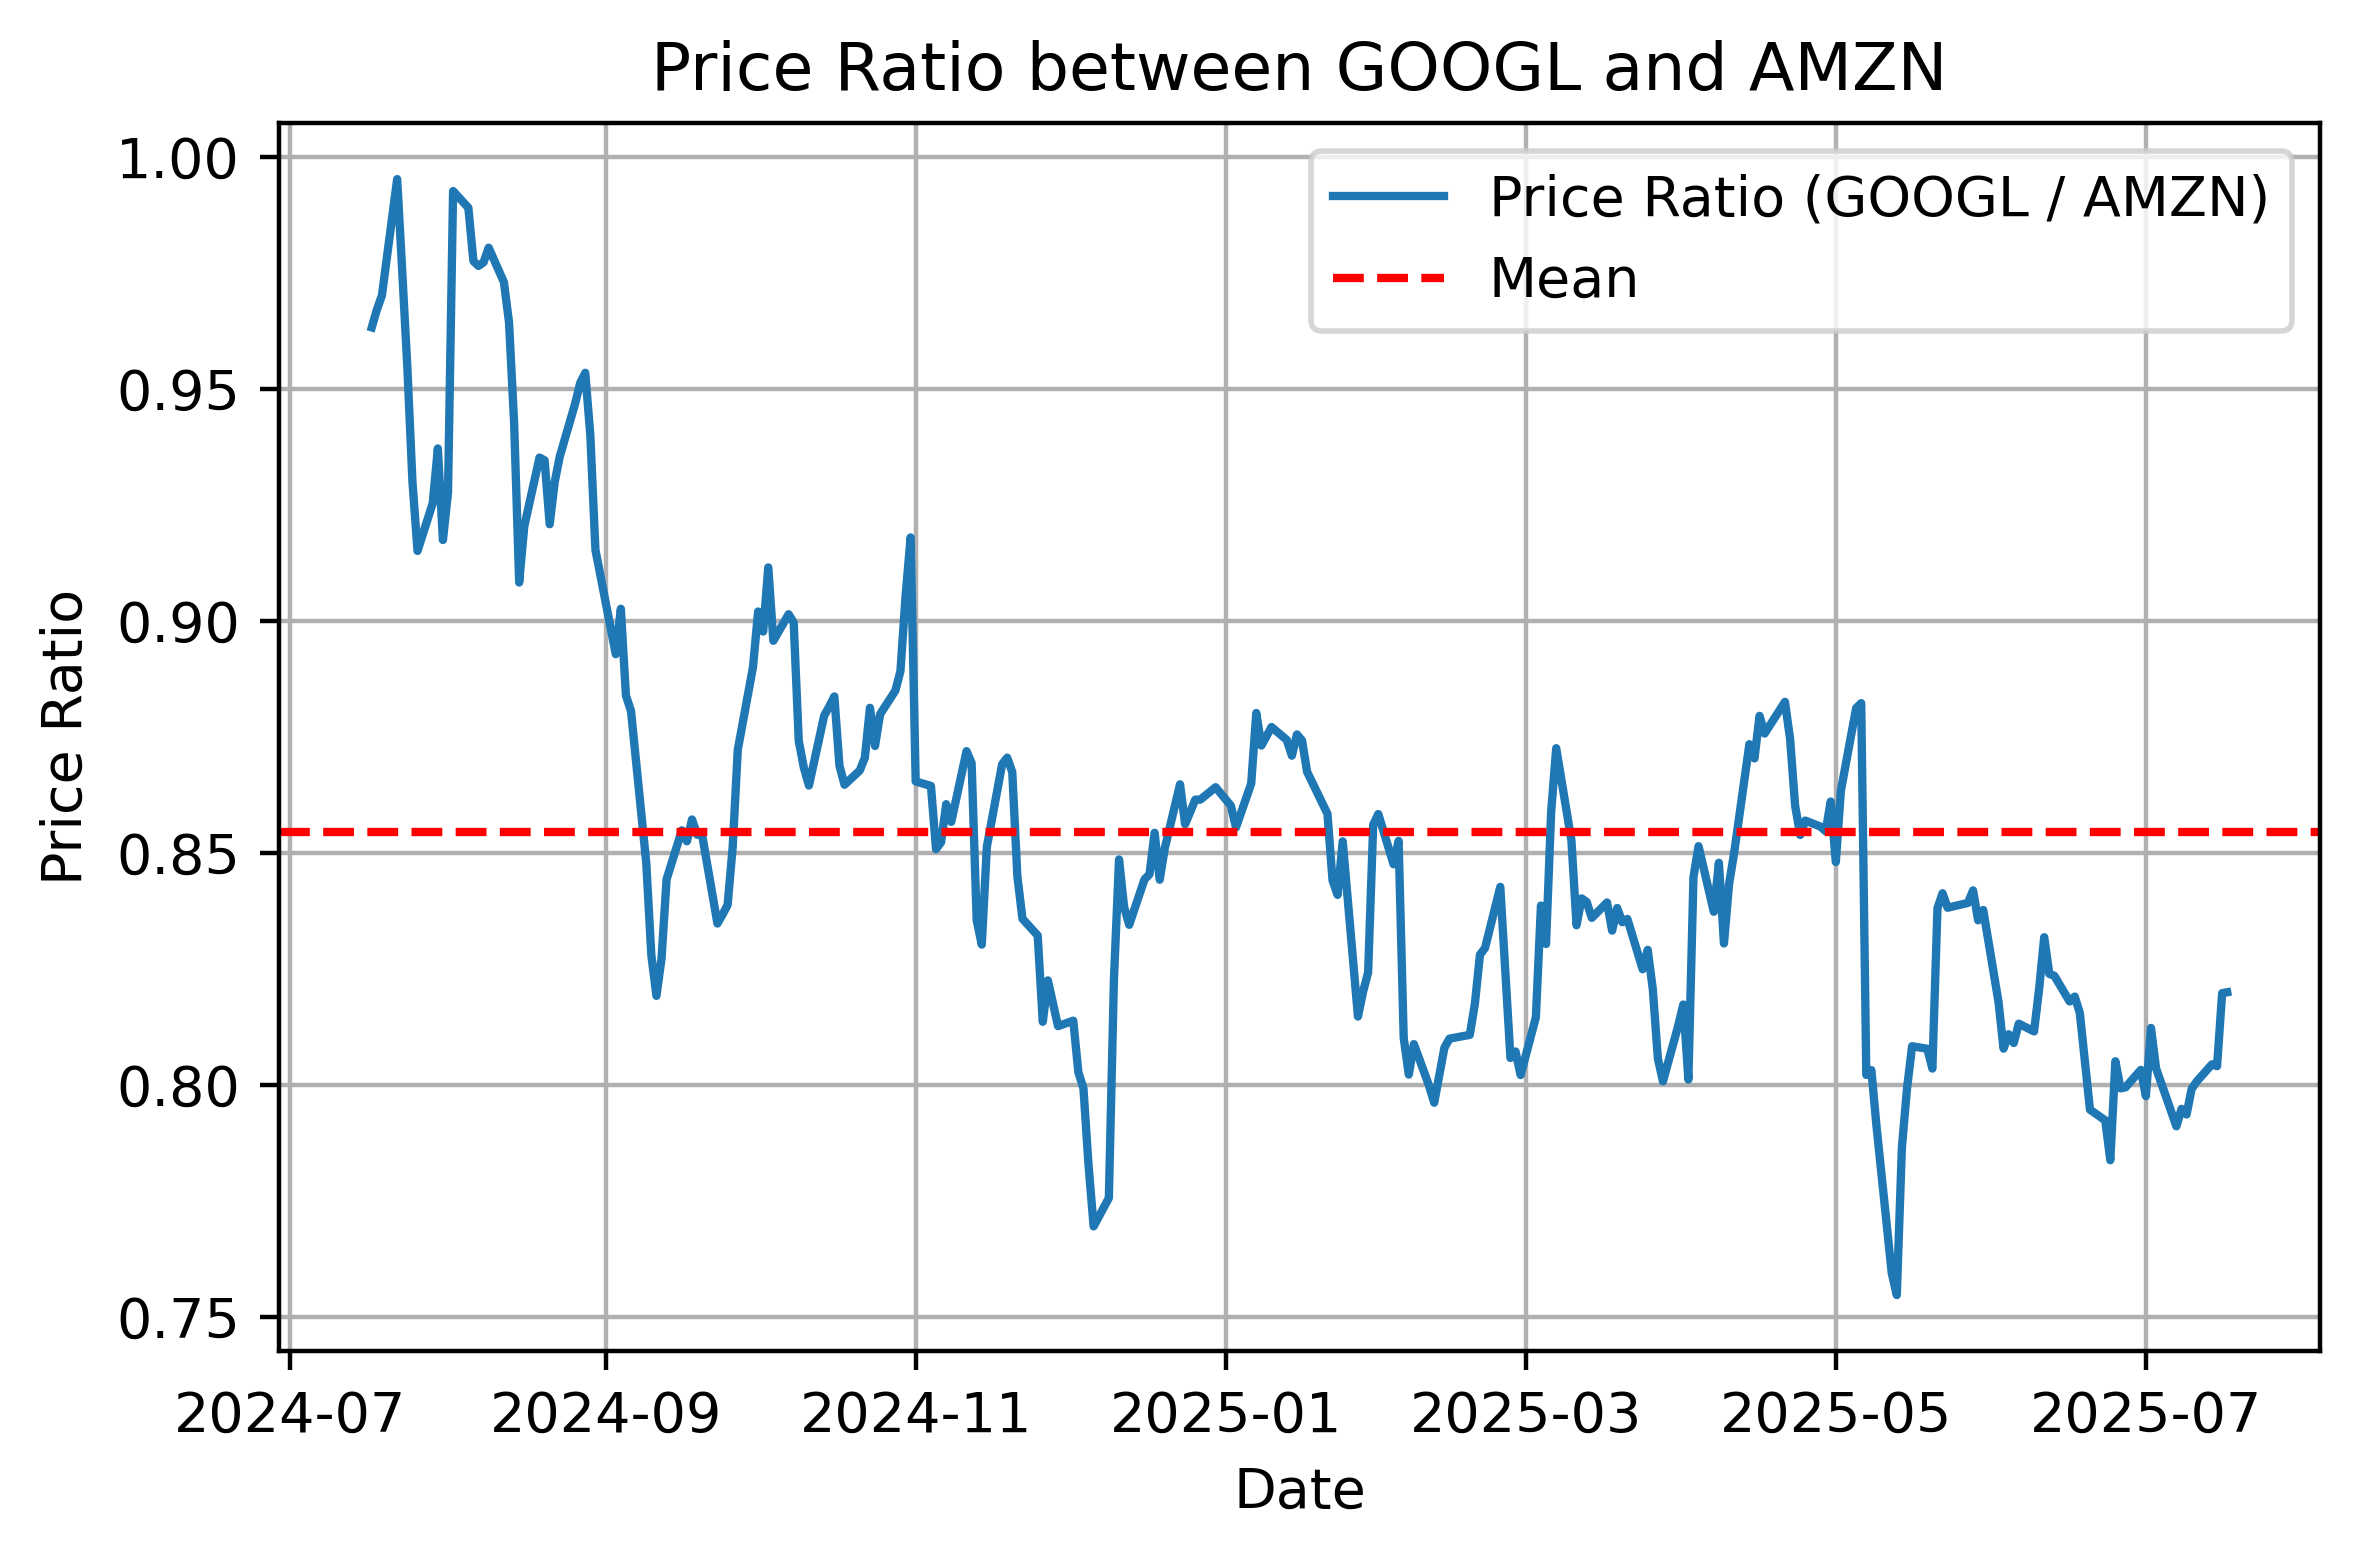

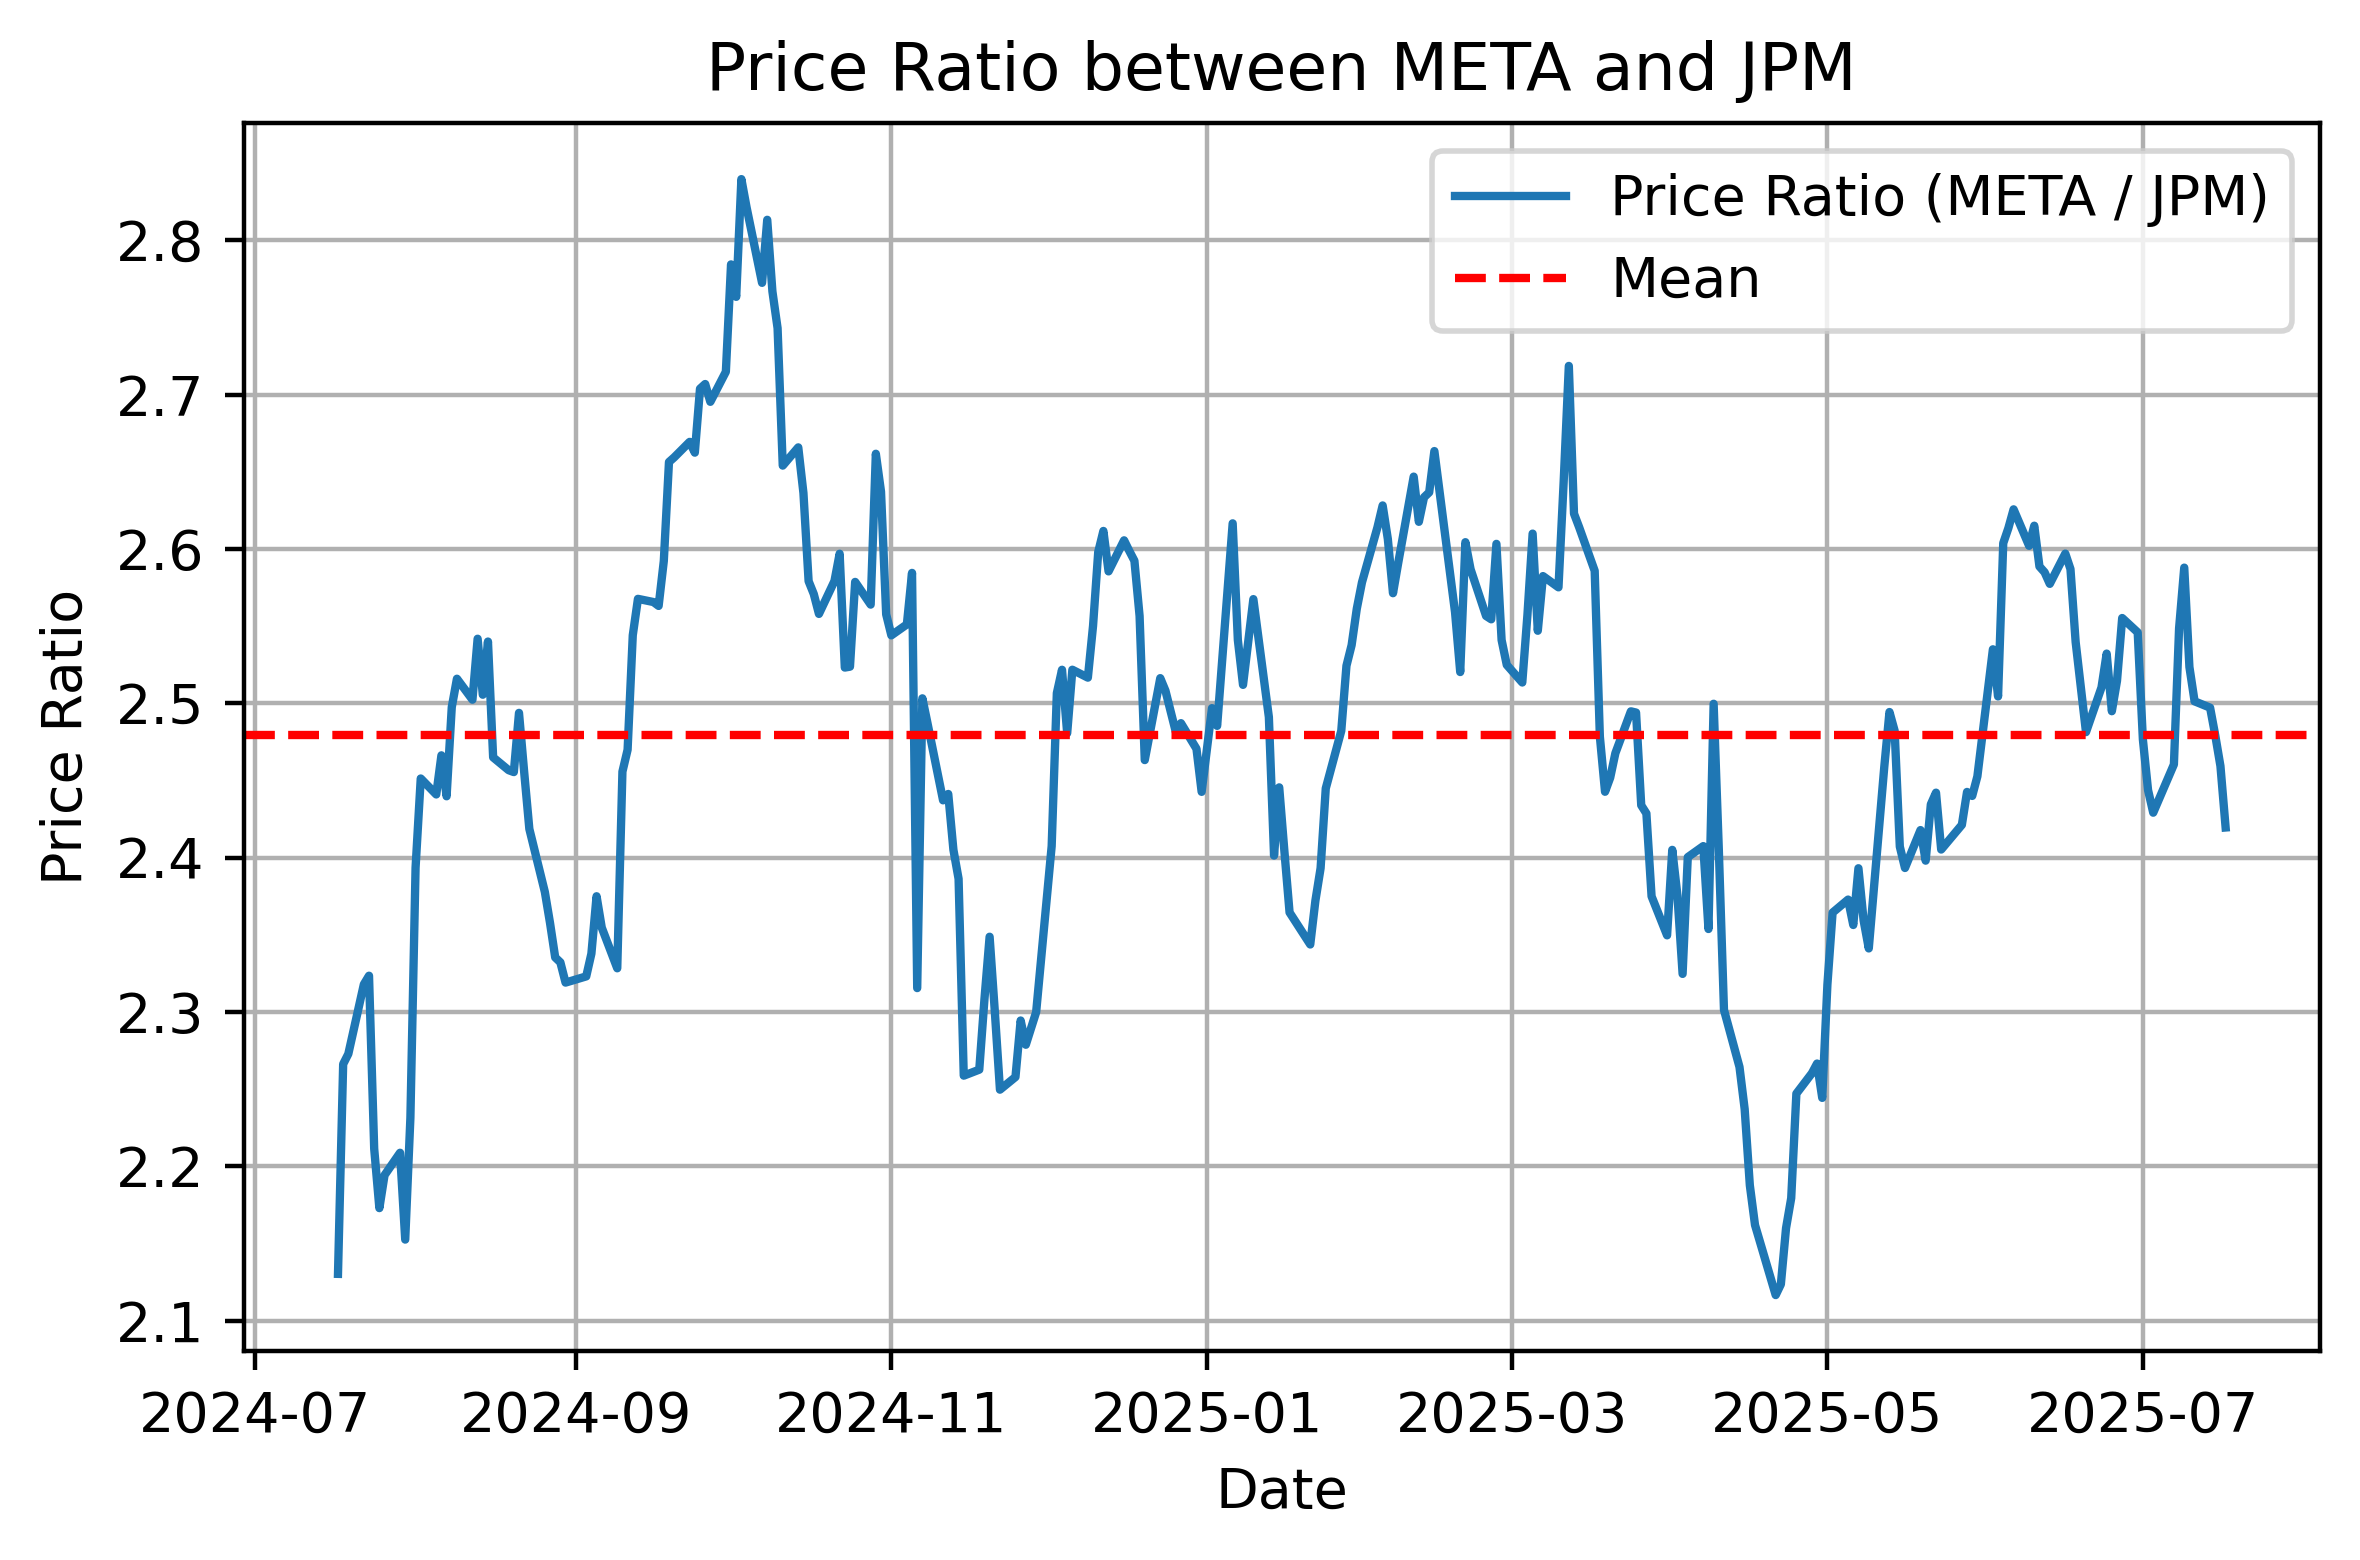

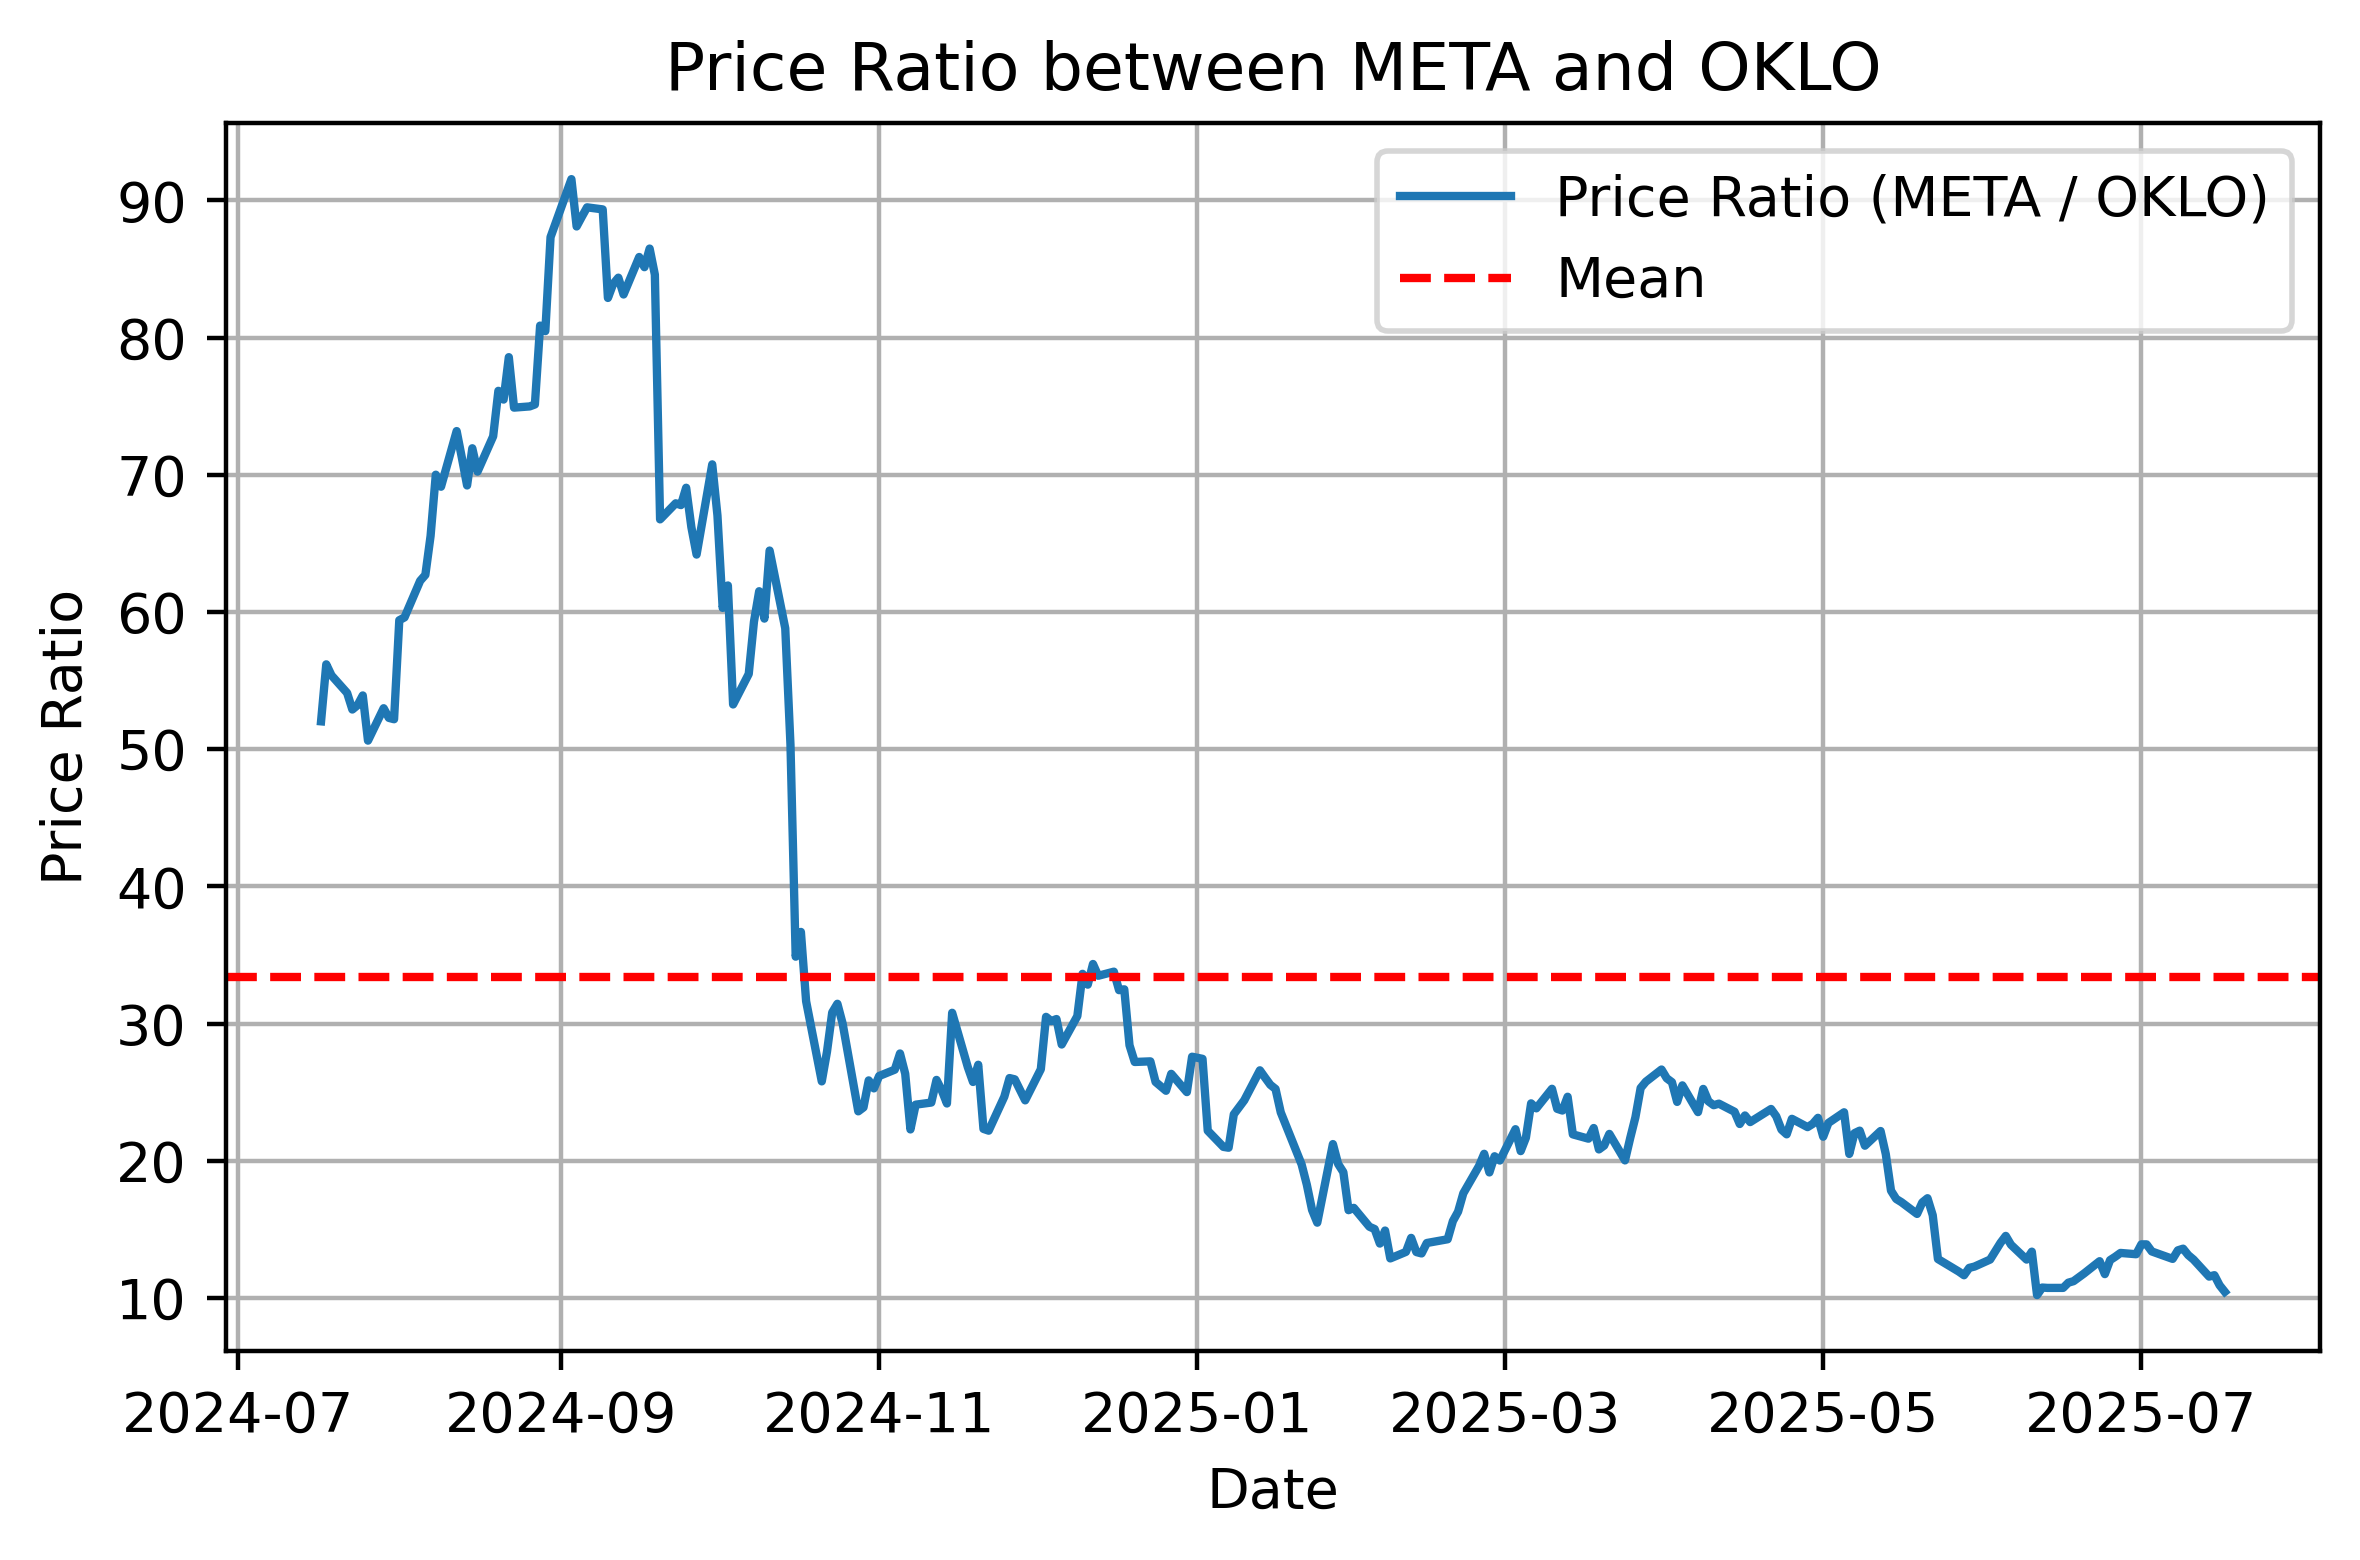

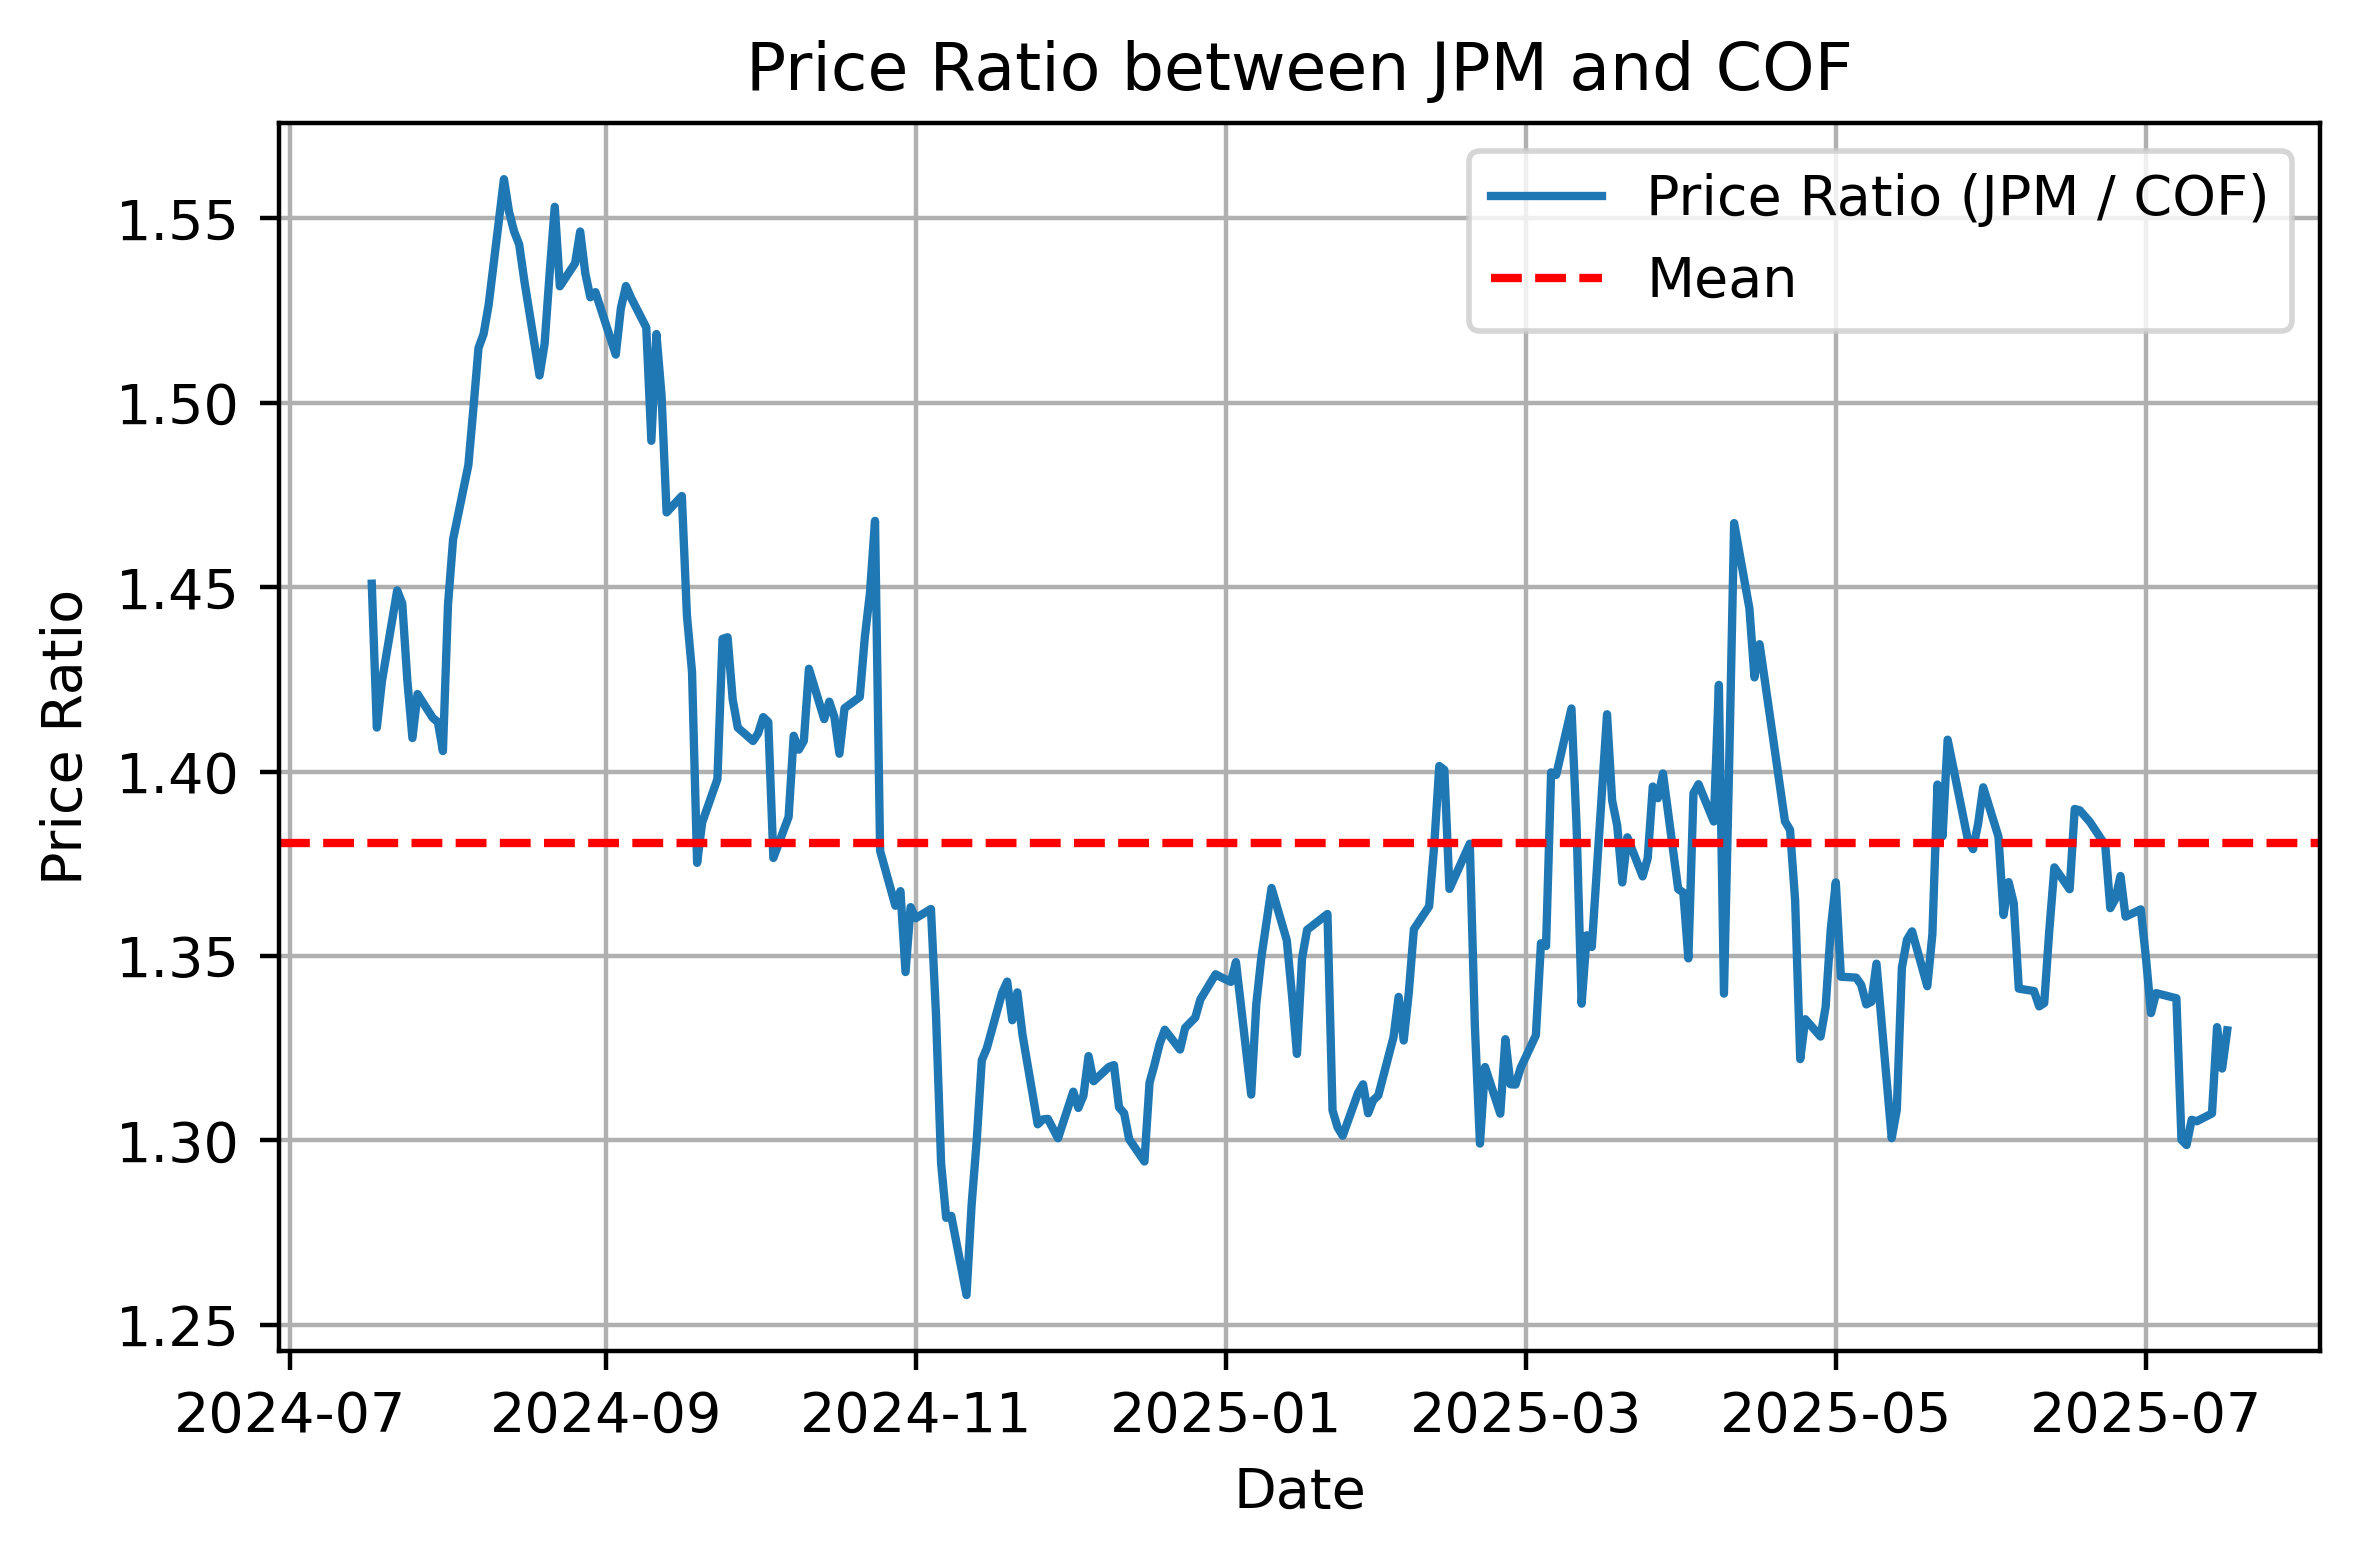

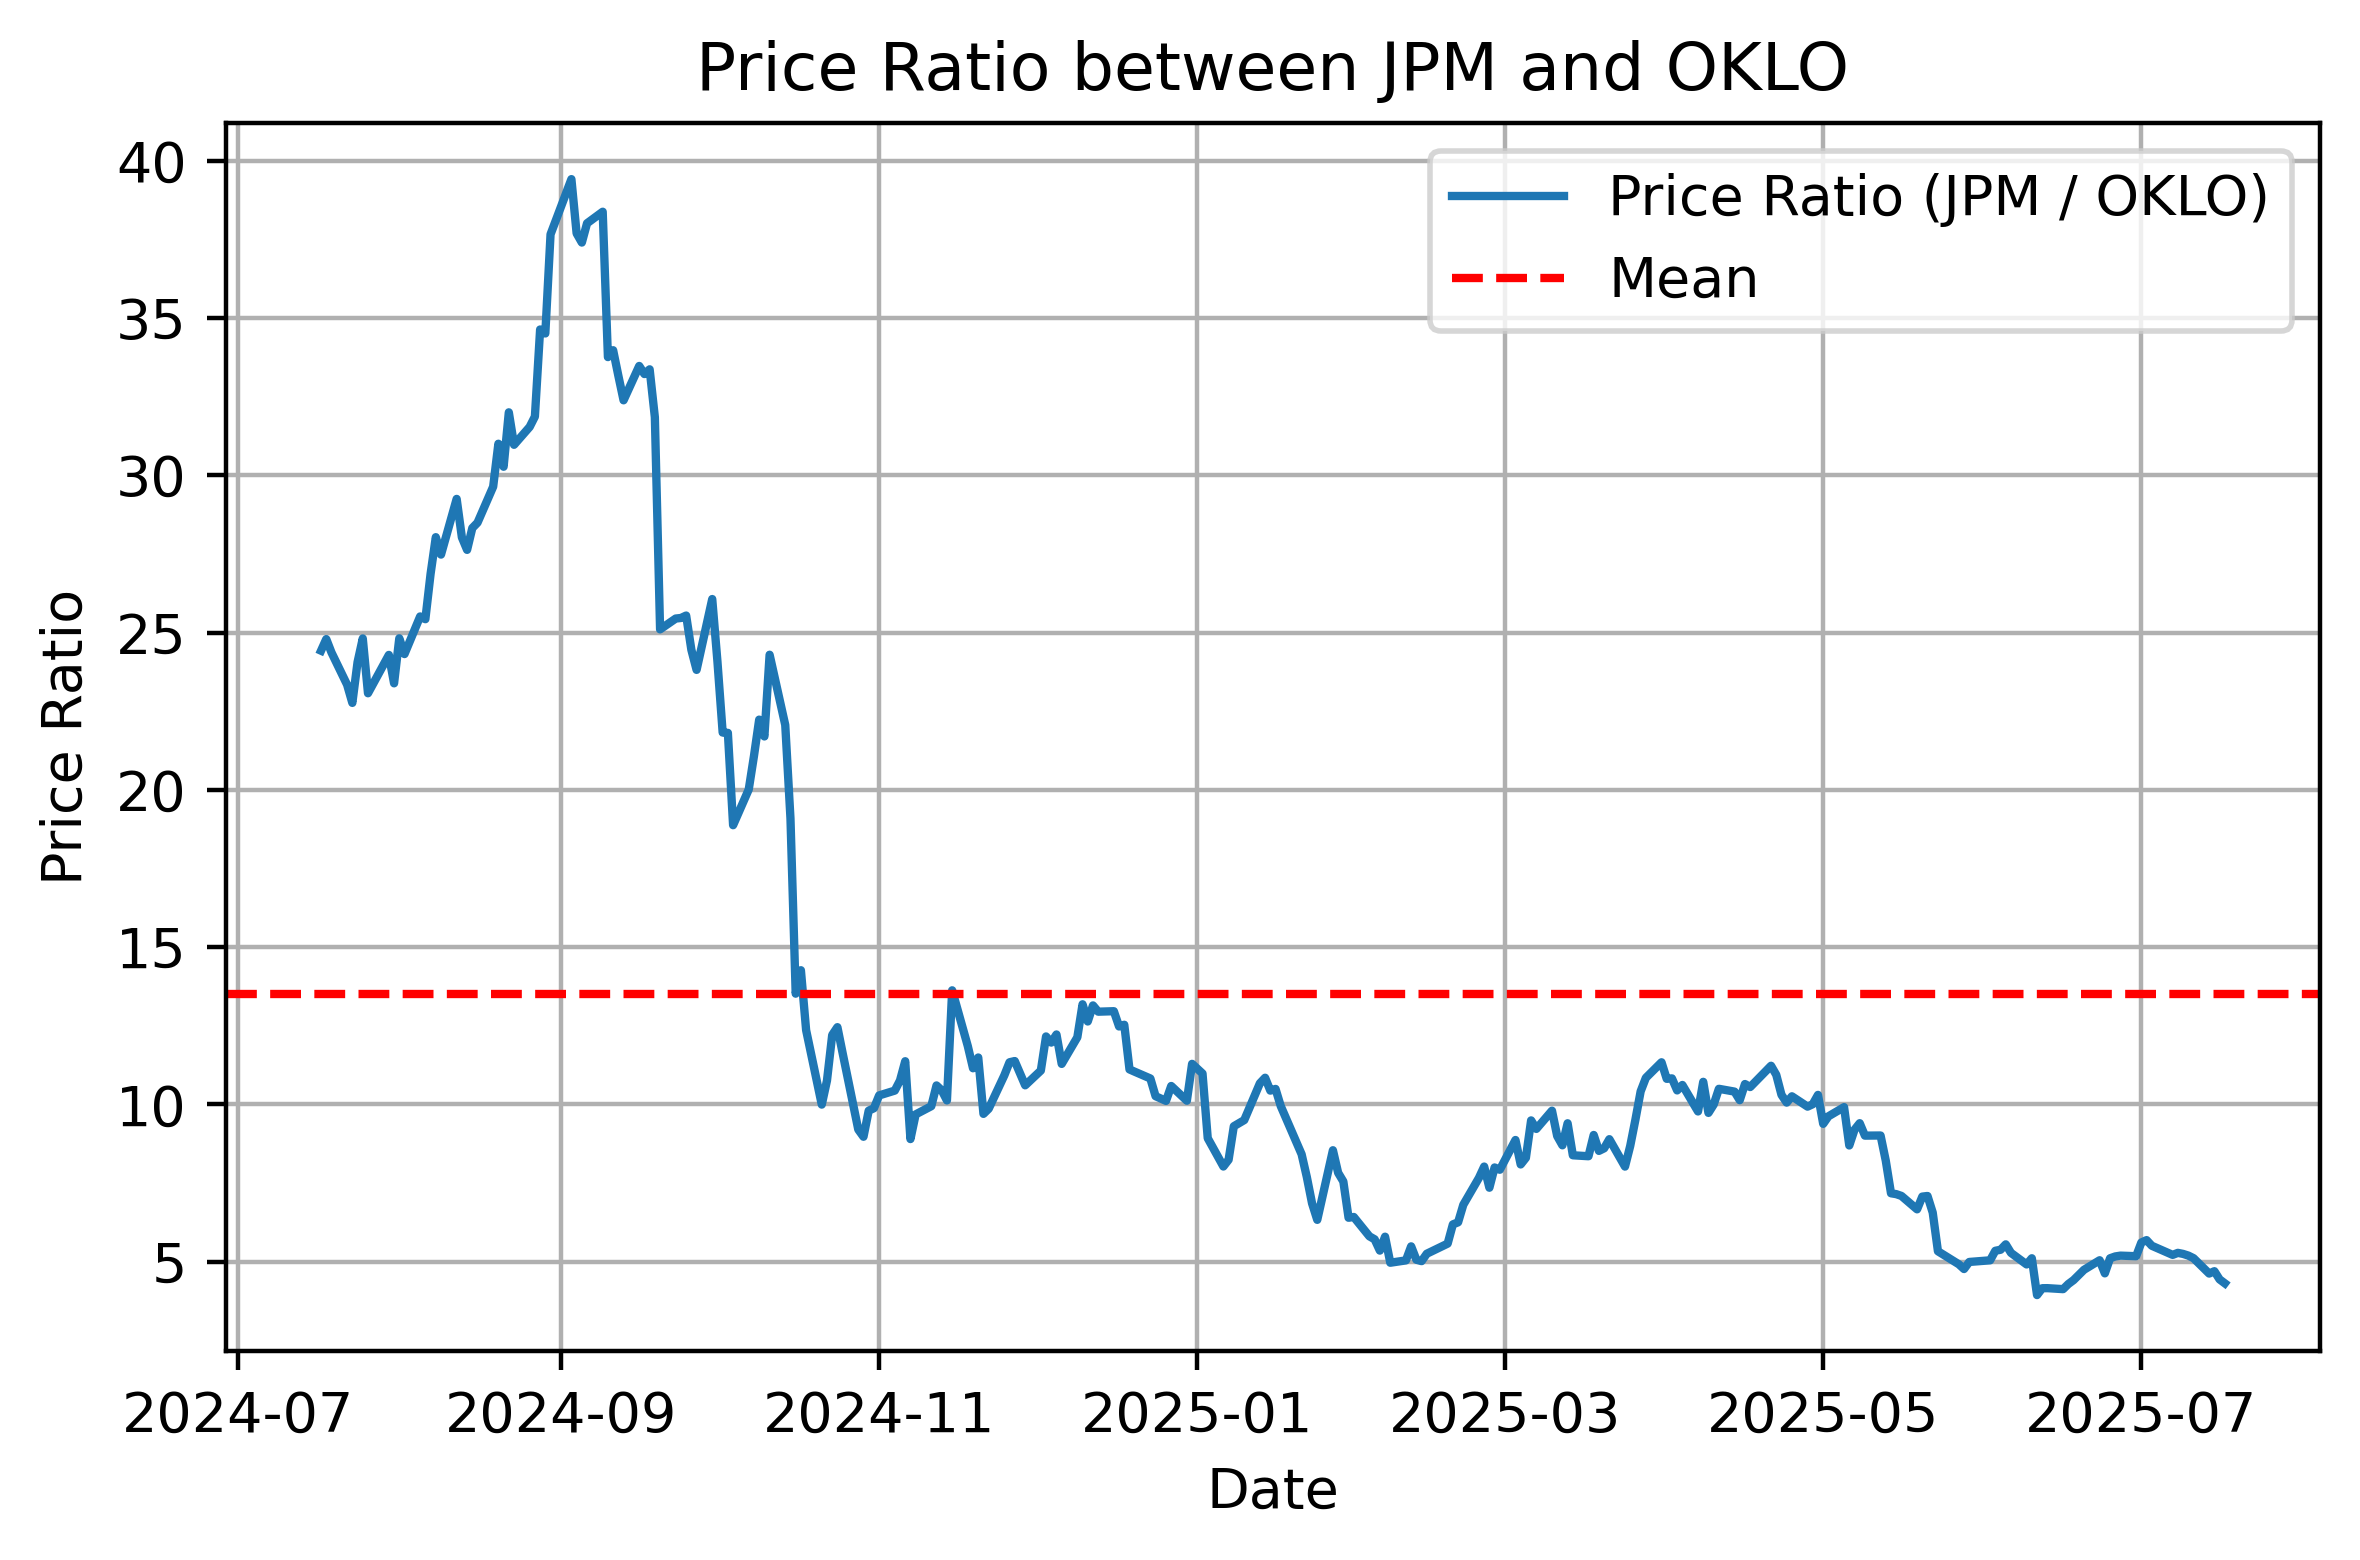

In [ ]:
def price_ratio_w_mean(spreads = stock_spread):
    # iterate through the big dictionary I made
    
    for keys, values in spreads.items():
        # directory 
        making = os.makedirs('./graphs/price_ratios/w_mean/', exist_ok = True)
        location = (f'./graphs/price_ratios/w_mean/')
        stock1,stock2 = keys[0], keys[1]
        ratio = values['ratio']
        figure(figsize = (6,4), dpi = 400)
        plt.plot(ratio, label=f'Price Ratio ({stock1} / {stock2})')
        plt.axhline(ratio.mean(), color='red', linestyle='--', label='Mean')
        plt.title(f'Price Ratio between {stock1} and {stock2}')
        plt.xlabel("Date")
        plt.ylabel("Price Ratio")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'{location} Price Ratio between {stock1} and {stock2}.png')

price_ratio_w_mean()

In [ ]:
def z_score_ratio():
    for key, values in stock_spread.items():
        os.makedirs('./graphs/price_ratios/z_score_ratios/',exist_ok = True)
        location = './graphs/price_ratios/z_score_ratios/'
        stock1,stock2 = key[0], key[1]
        z_score = (values['ratio'] - values['ratio'].mean()) / values['ratio'].std()
        z_score_mean = z_score.mean()
        figure(figsize = (6,4), dpi = 400)
        plt.plot(z_score, label = "Z Scores")
        plt.axhline(z_score_mean, color = 'black')
        plt.axhline(1.0, color='red') # Setting the upper and lower bounds to be the z score of 1 and -1 (1/-1 standard deviation)
        plt.axhline(1.25, color='red') # 95% of our data will lie between these bounds.
        plt.axhline(-1.0, color='green') # 68% of our data will lie between these bounds.
        plt.axhline(-1.25, color='green') # 95% of our data will lie between these bounds.
        plt.legend(loc = 'best')
        plt.title(f'Z score of Ratio of {stock1} to {stock2}')
        plt.savefig(f'{location}z_score_ratio_{stock1}_to_{stock2}')
        plt.close()
        
z_score_ratio()

In [ ]:
def rolling_avg_z_scores():
    for key, values in stock_spread.items():
        os.makedirs('./graphs/price_ratios/rolling_average_w_ratio/', exist_ok = True)

        location = './graphs/price_ratios/rolling_average_w_ratio/'
        
        stock1,stock2 = key[0], key[1]
        ratio = values['ratio']
        ratio_moving_avg_5 = values['ratio'].rolling(window =5, center = False).mean()
        ratio_moving_avg_20 = values['ratio'].rolling(window =20, center = False).mean()
        ratio_moving_avg_45 = values['ratio'].rolling(window =45, center = False).mean()

        std_20 = ratio.rolling(window = 20, center = False).std()
        std_45 = ratio.rolling(window = 45, center = False).std()

        z_score_20_5 = (ratio_moving_avg_5 - ratio_moving_avg_20) / std_20

        z_score_20_45 = (ratio_moving_avg_20 - ratio_moving_avg_45) / std_45

        figure(figsize = (6,4), dpi = 400)
        plt.plot(ratio.index, ratio.values)
        plt.plot(ratio_moving_avg_5.index, ratio_moving_avg_5.values)
        plt.plot(ratio_moving_avg_20.index, ratio_moving_avg_20.values)
        plt.plot(ratio_moving_avg_45.index, ratio_moving_avg_45.values)
        plt.legend(['Ratio', 'Rolling Average 5 Days', 'Rolling Average 20 Days', 'Rolling Average 45 Days'])
        plt.xlabel('Date')
        plt.ylabel('Ratio')
        plt.title(f'Ratio between {stock1} and {stock2} with 5, 20, 45 Day Moving Averages')
        plt.savefig(f'{location}price_ratio_of{stock1}_to_{stock2}_w_moving_averages')
        plt.close()
        
rolling_avg_z_scores()

In [ ]:
def moving_average_zscore_bands(spreads):

    directory = os.makedirs('./graphs/zscore_mavg_bands/', exist_ok = True)
    location = './graphs/zscore_mavg_bands/'
    for key,values in spreads.items():
        stock1,stock2 = key[0],key[1]
        ratio_moving_5 = values['ratio'].rolling(window =5, center = False).mean()
        ratio_moving_20 = values['ratio'].rolling(window =20, center = False).mean()
    
        z_score_5_20 = ((ratio_moving_5 - ratio_moving_20) / ratio_moving_20.std()).dropna()    
        bigger_band,big_band = round((max(z_score_5_20) - 0.25),1), round((max(z_score_5_20)- 0.50),1)
        smallest_band,small_band = round((min(z_score_5_20) + 0.25),1), round((min(z_score_5_20) + 0.50),1)
    
        if small_band > 0 or (big_band <=0 or 0.01 >= big_band <= .4) :
            break
    
        figure(figsize=(6, 4), dpi=200)
        z_score_5_20.plot()
        plt.axhline(0, color='black')
        plt.axhline(big_band, color='red', linestyle='--')
        plt.axhline(bigger_band, color='red', linestyle='--')
        plt.axhline(small_band, color='green', linestyle='--')
        plt.axhline(smallest_band, color='green', linestyle='--')
        plt.legend(['Rolling Ratio z-score', 'Mean', big_band,bigger_band,small_band,smallest_band])
        plt.title(f'{stock1} and {stock2} z relationship')
        plt.savefig(f'{location} {stock1} and {stock2} z relationship')
        plt.show()
        plt.close()


moving_average_zscore_bands()

In [ ]:
def buying_selling():
    directory = os.makedirs('./graphs/techniques/pairs_trading/buying_selling', exist_ok = True)
    location = './graphs/techniques/pairs_trading/buying_selling/'
    
    for keys,values in stock_spread.items():
        stock1,stock2 = key[0],key[1]
        ratio_moving_5 = values['ratio'].rolling(window =5, center = False).mean()
        ratio_moving_20 = values['ratio'].rolling(window =20, center = False).mean()
        z_score_5_20 = ((ratio_moving_5 - ratio_moving_20) / ratio_moving_20.std()).dropna() 

        figure(figsize=(6, 4), dpi=200)
        ratio = values['ratio']
        ratio.plot()
        buy = ratio.copy()
        sell = ratio.copy()
        buy.loc[z_score_5_20.index[z_score_5_20 > -1]] = 0
        sell.loc[z_score_5_20.index[z_score_5_20 < 1]] = 0

        buy.plot(color='g', linestyle='None', marker='^')
        sell.plot(color='r', linestyle='None', marker='^')
        x1, x2, y1, y2 = plt.axis()
        plt.axis((x1, x2, ratio.min(), ratio.max()))
        plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
        plt.ylabel(f'Ratio Price')
        plt.title(f'Relationship {stock1} to {stock2}')
        plt.savefig(f'{location} Relationship from {stock1} and {stock2} buy or sell?')
        plt.show()
        plt.close()


buying_selling()